In [1]:
with open('sample_name.txt','r') as f:
    name = f.read().split("\n")
    name_dict = {}
    for i in name:
        key, value = i.split(":")
        name_dict[key] = value
    number_of_samples = len(name_dict)

# 資料預處理

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,      #x坐标保持不变，而对应的y坐标按比例发生平移
                                   zoom_range = 0.2,       #可以让图片在长或宽的方向进行放大
                                   horizontal_flip = True) #水平翻转操作
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

Using TensorFlow backend.


In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255) 
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
training_set = train_datagen.flow_from_directory('train/', target_size = (64, 64), batch_size = 10,
                                                 class_mode = 'categorical')
validation_set = validation_datagen.flow_from_directory('validation/', target_size = (64, 64), batch_size = 10, 
                                                        class_mode = 'categorical')
test_set = test_datagen.flow_from_directory('test/', target_size = (64, 64), batch_size = 10, 
                                            class_mode = 'categorical')

Found 278 images belonging to 2 classes.
Found 71 images belonging to 2 classes.
Found 89 images belonging to 2 classes.


# 建立模型

In [5]:
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D 
from keras.layers import Flatten
from keras.layers import Dense

classifier = Sequential() # Initialising the CNN
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) # Convolution
classifier.add(MaxPooling2D(pool_size = (2, 2))) # Max Pooling
classifier.add(Conv2D(32, (3, 3), activation = 'relu')) # Convolution
classifier.add(MaxPooling2D(pool_size = (2, 2))) # Max Pooling
classifier.add(Flatten()) # Flattening
classifier.add(Dense(units = 128, activation = 'relu')) # Fully Connected
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = number_of_samples, activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss ='categorical_crossentropy', metrics = ['accuracy'])

# 訓練模型

In [6]:
# try:
#     classifier.load_weights("SaveModel/face.h5")
#     print("載入模型成功!繼續訓練模型")
# except :    
#     print("載入模型失敗!開始訓練一個新模型")

In [7]:
# https://keras-cn.readthedocs.io/en/latest/models/model/

In [8]:
history = classifier.fit_generator(training_set,
                                   nb_epoch=20,
                                   nb_val_samples=30,
                                   steps_per_epoch = 30,
                                   shuffle=True,
                                   verbose = 1,
                                   validation_data = validation_set)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., steps_per_epoch=30, shuffle=True, verbose=1, validation_data=<keras.pre..., epochs=20, validation_steps=30)`
  import sys


Epoch 1/20
30/30 [==============================] - 3s 95ms/step - loss: 0.6872 - acc: 0.5908 - val_loss: 0.6116 - val_acc: 0.6996
Epoch 2/20
30/30 [==============================] - 2s 78ms/step - loss: 0.4080 - acc: 0.8284 - val_loss: 0.4217 - val_acc: 0.8258
Epoch 3/20
30/30 [==============================] - 2s 74ms/step - loss: 0.3218 - acc: 0.8634 - val_loss: 0.3698 - val_acc: 0.8447
Epoch 4/20
30/30 [==============================] - 2s 71ms/step - loss: 0.1957 - acc: 0.9200 - val_loss: 0.3305 - val_acc: 0.8636
Epoch 5/20
30/30 [==============================] - 2s 74ms/step - loss: 0.1423 - acc: 0.9433 - val_loss: 0.3272 - val_acc: 0.8828
Epoch 6/20
30/30 [==============================] - 2s 74ms/step - loss: 0.0631 - acc: 0.9800 - val_loss: 0.3209 - val_acc: 0.9053
Epoch 7/20
30/30 [==============================] - 2s 70ms/step - loss: 0.0528 - acc: 0.9767 - val_loss: 0.4660 - val_acc: 0.8750
Epoch 8/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0727 - a

# 驗證曲線

In [9]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(history.history[train_acc])
    plt.plot(history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

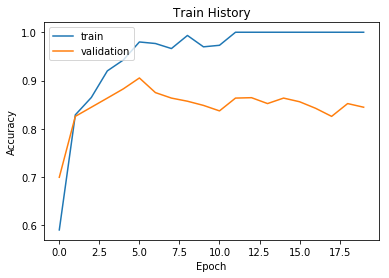

In [10]:
show_train_history('acc','val_acc')

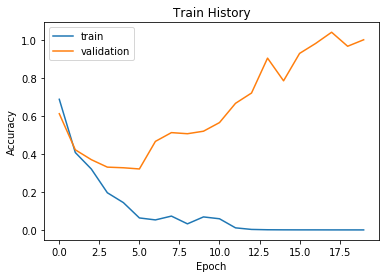

In [11]:
show_train_history('loss','val_loss')

# 模型預測

In [12]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'C:\Users\user\Desktop\thesis\Face_recognition_system - 20181128\sample0_face\ANd9GcQ_sEYrLtbHwuN9Fp56zdfUsfnZZRqGyBsrIcLovmjvrccWHK3R.jpg', target_size= (64,64))
test_image = image.img_to_array(test_image)
test_image.shape

(64, 64, 3)

In [13]:
test_image = np.expand_dims(test_image, axis = 0)
type(test_image)
test_image.shape

(1, 64, 64, 3)

In [14]:
classifier.predict_classes(test_image)

array([0], dtype=int64)

In [15]:
name_dict['sample'+str(classifier.predict_classes(test_image)[0])] 

'Jay Chou'

# 評估模型

In [16]:
import os

testset_path = []   #testset_path為所有testset圖片路徑的list
for i in os.listdir('test'):
    for j in os.listdir('test/'+i):
        testset_path.append('test/'+i+'/'+j)   

In [17]:
x_test_image = []
for path in testset_path:
    x_test_image.append(image.img_to_array(image.load_img(path, target_size= (64,64))))
x_test_image = np.array(x_test_image)/225

In [18]:
from keras.utils import np_utils
y_test_label = test_set.classes
y_Test_OneHot = np_utils.to_categorical(y_test_label)

In [19]:
test = []
for x, y, z in zip(x_test_image, y_test_label, y_Test_OneHot):
    test.append([x, y, z])

In [20]:
x_test_image = []
y_test_label = []
y_Test_OneHot = []
for i in test:
    x_test_image.append(i[0])
    y_test_label.append(i[1])
    y_Test_OneHot.append(i[2])
x_test_image = np.array(x_test_image)
y_test_label = np.array(y_test_label)
y_Test_OneHot = np.array(y_Test_OneHot)

In [21]:
prediction = classifier.predict_classes(x_test_image)               #預測

In [22]:
scores = classifier.evaluate(x_test_image, y_Test_OneHot, verbose=0)  #評估
scores[1]

0.92134831929474736

In [23]:
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title= "label=" +str(labels[idx])
        if len(prediction)>0:
            title+=",predict="+str(prediction[idx]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


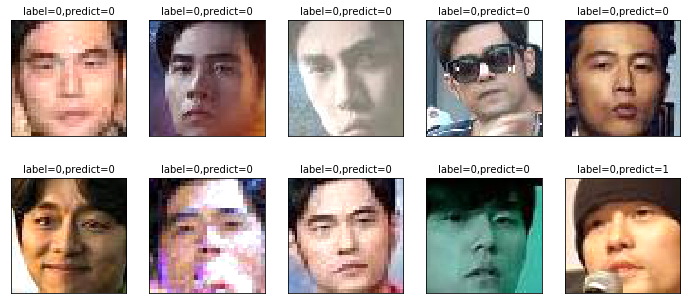

In [24]:
plot_images_labels_prediction(x_test_image,y_test_label,prediction,idx=10)

# 混淆矩陣

In [25]:
import pandas as pd
pd.crosstab(y_test_label,prediction,rownames=['label'],colnames=['predict'])

predict,0,1
label,,
0,41,3
1,4,41


# 儲存模型

In [26]:
import os

if not os.path.exists('SaveModel'):
    os.mkdir('SaveModel')
# classifier.save_weights("SaveModel/face.h5")
classifier.save('SaveModel/face.hd5')
print("Saved model to disk")

Saved model to disk
